**Question 2:** Analyze the data and make justifications on why the peak load use was the 
hour that it was.

In [11]:
# Import libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Step 1: Data Collection and Preprocessing**\
\
**a. Import Rhode Island data file and clean data types**
> I imported the Rhode Island electricity load data as a pandas dataframe and cleaned the time column to be separated into date and hour.\
Also, I dropped the time and zonal_name columns since they won't be useful for this analysis.

In [12]:
cd = os.getcwd()
file = cd[:-7] + 'Data/RI-2024-10.csv' # Change so this works in folder structure for another PC.
ri_load_df = pd.read_csv(file)
ri_load_df['time'] = pd.to_datetime(ri_load_df['time'])
ri_load_df['date'] = ri_load_df['time'].dt.date
ri_load_df['hour'] = ri_load_df['time'].dt.hour

ri_load_df = ri_load_df.drop(columns = ['time', 'zonal_name'])

display(ri_load_df.head(5))
ri_load_df.dtypes

,load,date,hour
0,609.207,2024-10-01,5
1,598.181,2024-10-01,6
2,578.324,2024-10-01,7
3,646.755,2024-10-01,8
4,768.010,2024-10-01,9


load    float64
date     object
hour      int32
dtype: object

**b. What hour has the highest load?**
> I want to find which date and hour had the highest load so I can collect weather data for the surrounding days.\
Normally we would have a data feed so I could analyze all hours in October 2024 but that will take too much time for this assignment.\
The peak load ocurred on **October 4 at hour ending 19 (7pm)**. I will collect data for the surrounding days and import into the notebook.

In [13]:
max_load_row = ri_load_df[ri_load_df['load'] == ri_load_df['load'].max()]
print(f"Max load in Rhode Island in October 2024 happened on {max_load_row['date'].iloc[0]} at hour {max_load_row['hour'].iloc[0]}")

Max load in Rhode Island in October 2024 happened on 2024-10-04 at hour 19


**c. Import Providence weather data**
> I chose to use weather data from Providence because it is the largest city in Rhode Island, so it should be one of largest contributors to the state's overall load.\
I removed some of the extra rows and added the hour column in Excel so I can merge to the demand data provided.\
Source: https://www.timeanddate.com/weather/usa/providence/historic?month=10&year=2024

In [14]:
file = cd[:-7] + 'Data/providence_weather_data.csv'
weather_df = pd.read_csv(file, encoding='latin1')

weather_df['temperature'] = weather_df['temperature'].str.replace( "°C", "").astype(float)
weather_df['wind'] = weather_df['wind'].str.replace( "km/h", "", regex = False).replace("No wind", 0).astype(float)
weather_df['humidity'] = weather_df['humidity'].str.replace( "%", "").astype(float)
weather_df['barometer'] = weather_df['barometer'].str.replace( "kPa", "").astype(float)
weather_df['visibility'] = weather_df['visibility'].str.replace( "km", "").astype(float)
weather_df['hour'] = weather_df['hour'].astype('int32')
weather_df['date2'] = pd.to_datetime(weather_df['date']).dt.date

weather_df = weather_df.drop(columns = ['date'])
weather_df = weather_df.rename(columns={'date2': 'date'})

load_weather_df = ri_load_df.merge(weather_df, on = ['date', 'hour'], how = 'inner')
load_weather_df['weekday'] = pd.to_datetime(load_weather_df['date']).dt.day_name()

display(load_weather_df)


,load,date,hour,temperature,weather,wind,humidity,barometer,visibility,weekday
0,598.181,2024-10-01,6,13.0,Passing clouds.,9.0,100.00,101.94,11.0,Tuesday
1,578.324,2024-10-01,7,14.0,Fog.,11.0,100.00,101.94,3.0,Tuesday
2,646.755,2024-10-01,8,14.0,Fog.,13.0,100.00,101.97,2.0,Tuesday
3,768.010,2024-10-01,9,16.0,Partly sunny.,20.0,96.00,101.99,16.0,Tuesday
4,792.199,2024-10-01,10,18.0,Broken clouds.,17.0,81.00,102.01,16.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...
282,867.112,2024-10-14,19,12.0,Passing clouds.,11.0,0.86,100.23,16.0,Monday
283,871.548,2024-10-14,20,12.0,Passing clouds.,17.0,0.69,100.35,16.0,Monday
284,897.331,2024-10-14,21,11.0,Passing clouds.,17.0,0.74,100.44,16.0,Monday
285,929.753,2024-10-14,22,10.0,Passing clouds.,22.0,0.71,100.61,16.0,Monday


**Step 2: Feature Engineering**\
\
**a. Find optimal base temperature to calculate CDD**
> I wanted to find the best base temperature to calcualate CDD. Below is a quick way of finding it.

In [15]:
# Check optimal base temp for CDD based on correlation.

base_temperatures = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]

def calculate_cdd(temperature, base_temp):
    return max(0, temperature - base_temp)

correlation_results = {}

for base_temp in base_temperatures:
    load_weather_df[f'cdd_{base_temp}'] = load_weather_df['temperature'].apply(lambda x: calculate_cdd(x, base_temp))
    
    correlation = load_weather_df[f'cdd_{base_temp}'].corr(load_weather_df['load'])
    correlation_results[base_temp] = correlation

best_base_temp = max(correlation_results, key=correlation_results.get)
print(f"The best base temperature for cooling degree days is {best_base_temp}°C with a correlation of {correlation_results[best_base_temp]:.2f}")

The best base temperature for cooling degree days is 4.0°C with a correlation of 0.35


In [16]:
load_weather_df = load_weather_df[['date', 'weekday', 'hour', 'load', 'temperature', 'cdd_4.0', 'wind', 'humidity', 'barometer', 'visibility']]
display(load_weather_df.head())

,date,weekday,hour,load,temperature,cdd_4.0,wind,humidity,barometer,visibility
0,2024-10-01,Tuesday,6,598.181,13.0,9.0,9.0,100.0,101.94,11.0
1,2024-10-01,Tuesday,7,578.324,14.0,10.0,11.0,100.0,101.94,3.0
2,2024-10-01,Tuesday,8,646.755,14.0,10.0,13.0,100.0,101.97,2.0
3,2024-10-01,Tuesday,9,768.010,16.0,12.0,20.0,96.0,101.99,16.0
4,2024-10-01,Tuesday,10,792.199,18.0,14.0,17.0,81.0,102.01,16.0


**b. Review load data distribution and create transformation**
> Before moving onto exploratory analysis, I want to evaluate the skewness of the load data. As you can see below, load data is normally left skewed so a data transformation might be useful later.\
The log transformed data provides a more normal distribution which might optimize performance.

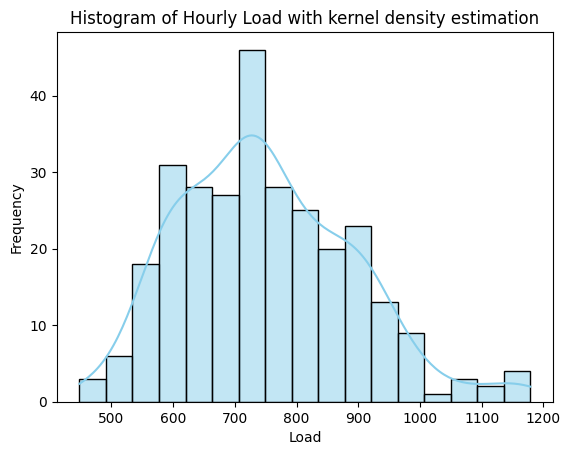

In [17]:
load_data = load_weather_df['load']

bin_num = np.sqrt(load_data.count()).round(0).astype('int')
sns.histplot(load_data, kde = True, bins = bin_num, color = 'skyblue')

plt.xlabel('Load')
plt.ylabel('Frequency')
plt.title('Histogram of Hourly Load with kernel density estimation')
plt.show()

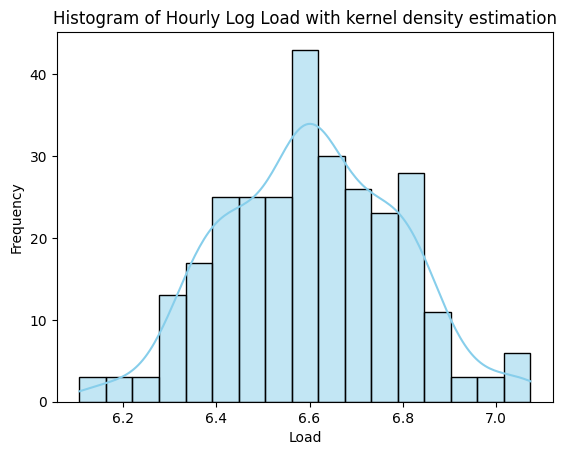

In [27]:
load_weather_df['load_log'] = np.log(load_weather_df['load'] + 1)
load_log_data = load_weather_df['load_log']

bin_num = np.sqrt(load_data.count()).round(0).astype('int')
sns.histplot(load_log_data, kde = True, bins = bin_num, color = 'skyblue')

plt.xlabel('Load')
plt.ylabel('Frequency')
plt.title('Histogram of Hourly Log Load with kernel density estimation')
plt.show()

**c. Time of Day**
> Adding time of day features represented as a continuous variable. Transforming the hour column into sine and cosines should assist in categorizing the data closer to something like "Morning", "Afternoon", and "Evening".\
I believe there is some cyclical structure to the data where demand always peaks in the evening as workers return home, I believe these features will be good at representing that.

In [45]:
load_weather_df['hour_sin'] = np.sin(2 * np.pi * load_weather_df['hour'] / 24)
load_weather_df['hour_cos'] = np.cos(2 * np.pi * load_weather_df['hour'] / 24)

**d. Day of Week**
> Similar logic to Time of Day. Demand should be higher during week days especially if there is a high industrial load in Rhode Island.\
I want to test these features in case there is some cyclical pattern based on the day of the week.

In [47]:
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
load_weather_df['day_of_week_num'] = pd.to_datetime(load_weather_df['date']).dt.day_name().map(day_mapping)

load_weather_df['day_of_week_sin'] = np.sin(2 * np.pi * load_weather_df['day_of_week_num'] / 7)
load_weather_df['day_of_week_cos'] = np.cos(2 * np.pi * load_weather_df['day_of_week_num'] / 7)


**e. Add Interactive Features to Capture Weather** 
> Testing a couple of interavtive features since they may better represent their variables together than independently.

In [ ]:
load_weather_df['cdd_hum'] = load_weather_df['cdd_4.0'] * load_weather_df['humidity']
load_weather_df['wind_temp'] = load_weather_df['wind'] * load_weather_df['cdd_4.0']

**Step 3: Exploratory Data Analysis**
> The purpose of this step is to visualize the data so I can explain why peak demand was highest on October 4th at 7pm using the collected weather data.

**a. Testing Thermal Inertia**
> I want to test a lag variable that averages the last 8 hours of cooling degree days. My theory is based on the fact demand seems to peak around 7pm every day when people are likely ending their work day.\
\
As displayed below, the lag feature is not quite as effective as I hoped. It might be something that could be used in a model but it would likely not have a significant impact.

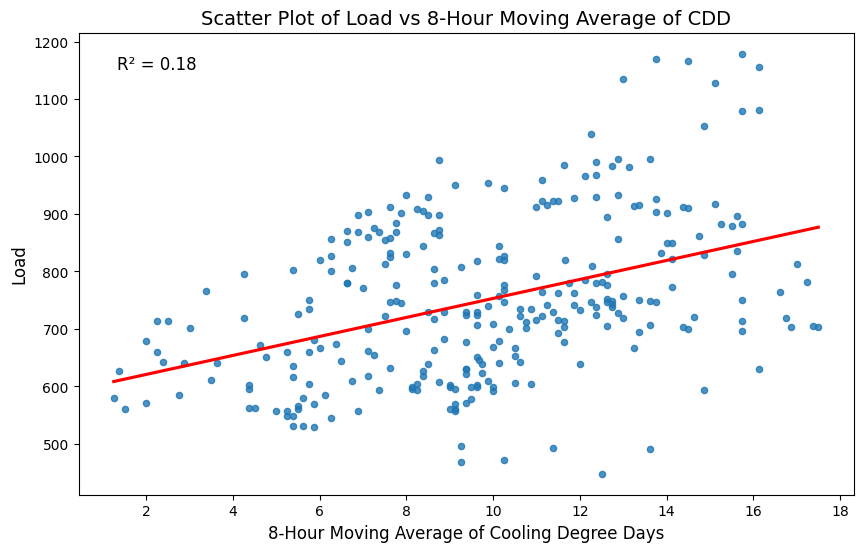

In [24]:
from scipy import stats

load_weather_df['cdd_8hr_avg'] = load_weather_df['cdd_4.0'].rolling(window = 8, min_periods = 1).mean()

plt.figure(figsize=(10, 6))

# Create the scatter plot with a trendline
sns.regplot(x='cdd_8hr_avg', y='load', data = load_weather_df, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci=None)

# Calculate the R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(load_weather_df['cdd_8hr_avg'], load_weather_df['load'])
r_squared = r_value**2

# Add a title and labels
plt.title('Scatter Plot of Load vs 8-Hour Moving Average of CDD', fontsize=14)
plt.xlabel('8-Hour Moving Average of Cooling Degree Days', fontsize=12)
plt.ylabel('Load', fontsize=12)

# Display the R-squared value on the plot
plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show the plot
plt.show()

**b. Correlation Matrix**
> This matrix is showing that no one individual variable is significantly affecting hourly load for the dates. There seems to be many variables that have a slight affect on the hourly load.

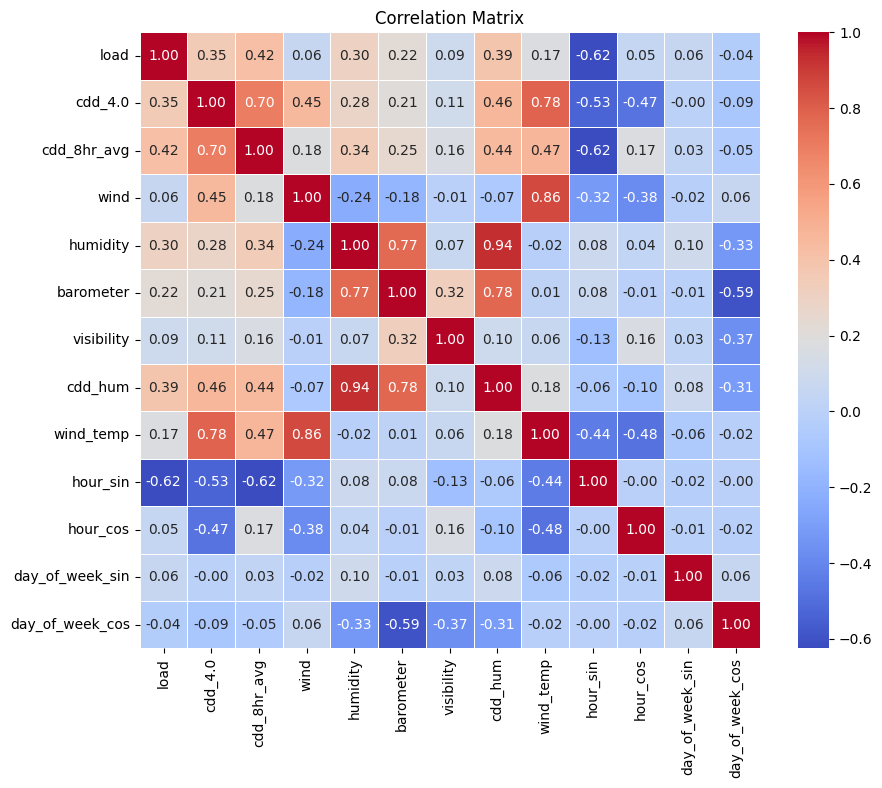

In [49]:
correlation_data = load_weather_df[['load', 'cdd_4.0', 'cdd_8hr_avg', 'wind', 'humidity', 'barometer', 'visibility', 
                                    'cdd_hum', 'wind_temp', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()

**Step 4: Regression Analysis to Explain Peak Demand**
> I'm creating a multiple linear regression model to analyze which variables I can use to confidently explain why peak demand ocurred on October 4th at 7pm.\
The intent is not to use this model for predictions but to justify to a stakeholder what factors likely contributed to Rhode Island peak demand in October 2024.\
A linear regression model is likely not the best model type to predict peak load but it is easier to understand and explain past behavior to stakeholders.

**a. Initial Regression Model**
> This is the initial regression model using the most attractive features I created.\
I will only keep features with a p-value less than 0.05 since they are likely insignicant at explaining hourly load. I only want to keep features where there is a high confidence.

In [54]:
import statsmodels.api as sm

X = load_weather_df[['cdd_4.0', 'cdd_8hr_avg', 'wind', 'humidity', 'barometer', 'visibility', 'cdd_hum', 'wind_temp', 'hour_sin', 'hour_cos']]
y = load_weather_df['load'] 
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   load   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     36.13
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           1.19e-44
Time:                        12:20:46   Log-Likelihood:                -1705.4
No. Observations:                 287   AIC:                             3433.
Df Residuals:                     276   BIC:                             3473.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2033.9877   1989.090      1.023      

**b. Final Regression Model**
> Based on the initial model, I reduced the features to: the 8-hour CDD lag, CDD/Humidity, and Hour Cosine variables.\
These three features explain about 55.5% of the fluctuations in hourly load for the selected time period.

In [55]:
X = load_weather_df[['cdd_8hr_avg', 'cdd_hum', 'hour_sin', 'hour_cos']]
y = load_weather_df['load'] 
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   load   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     90.07
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           3.16e-49
Time:                        12:20:59   Log-Likelihood:                -1707.4
No. Observations:                 287   AIC:                             3425.
Df Residuals:                     282   BIC:                             3443.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         823.7989     22.498     36.617      

**Conclusion**
> The electricity load in Rhode Island peaked on October 4th at 7 p.m. for several reasons. First, the prior eight hours in Providence were relatively warm, averaging around 20°C, which likely caused buildings to heat up, making indoor temperatures uncomfortable. Additionally, at 7 p.m., the conditions remained warm and humid. Finally, Rhode Island's electricity demand typically peaks in the evening as people return home from work.
\
In summary, while the weather wasn't extreme, the combination of warm temperatures and high humidity during the typical peak demand hour contributed to the rise in electricity load on October 4th.

**Next Steps**
> While the current model explains about 55.5% of the variance in electricity load, there are opportunities to improve its explanatory power. One approach is to explore additional feature engineering, such as creating new variables based on different time intervals. Given that electricity demand is often difficult to predict during shoulder seasons, continuous model improvements will be necessary to capture these variations more effectively.